Below is a “drop-in” long-form summary of what we discussed about **Hamiltonian Variational Ansatz (HVA)**, written so you can paste it into your notebook/README and come back to it later. I’m keeping the math explicit.

---

# Hamiltonian Variational Ansatz (HVA): what it is, why it can be efficient, and why we won’t use “truncated HVA” in v1

## 0) Context: what problem VQE is solving

In VQE, we pick a parameterized state
[
|\psi(\boldsymbol\theta)\rangle = U(\boldsymbol\theta),|\psi_0\rangle
]
and minimize the variational energy
[
E(\boldsymbol\theta) ;=; \langle \psi(\boldsymbol\theta)|,H,|\psi(\boldsymbol\theta)\rangle.
]
By the variational principle, (E(\boldsymbol\theta)\ge E_0) (ground energy), and if the ansatz family contains (or approximates) the true ground state, the minimum gets close to (E_0).

Crucially: **the “ground-state seeking” is done by energy minimization**, not by the fact that gates look like “time evolution”.

---

## 1) What HVA is (definition)

HVA is a VQE ansatz where the circuit is built from exponentials of **Hamiltonian pieces**. If the Hamiltonian decomposes as
[
H = \sum_{k} H_k
]
then HVA uses a unitary of the form
[
U(\boldsymbol\theta) ;=; \prod_{\ell=1}^{p}\prod_{k} e^{-i,\theta_{\ell,k},H_k}.
]

### Common “physics split” for 1D grid Hamiltonians

For 1D single-particle problems discretized on a finite-difference grid, you naturally have:
[
H = T + V,
]
where

* (T) is the kinetic (second-derivative stencil matrix),
* (V) is diagonal in the position basis.

A plain HVA choice is:
[
U(\boldsymbol\theta) ;=; \prod_{\ell=1}^{p} \Big( e^{-i,\alpha_\ell,V}; e^{-i,\beta_\ell,T}\Big).
]
This uses **2 parameters per layer** ((\alpha_\ell,\beta_\ell)).

---

## 2) Why “(e^{-iHt})” doesn’t cool to the ground state (and why HVA still works)

Real-time evolution under a *fixed* Hamiltonian,
[
|\psi(t)\rangle = e^{-iHt}|\psi(0)\rangle,
]
does **not** generally push you toward the ground state. In the energy eigenbasis,
[
|\psi(0)\rangle = \sum_n c_n |E_n\rangle
\quad\Rightarrow\quad
|\psi(t)\rangle = \sum_n c_n e^{-iE_n t}|E_n\rangle,
]
so the probabilities (|c_n|^2) are unchanged—only phases rotate.

**HVA is not “let time evolution cool you”.**
HVA is: *choose a structured family of unitaries generated by physics terms, then minimize energy over the parameters.*

Also, HVA usually alternates multiple generators (e.g., (T) and (V)), and those pieces typically do **not** commute with each other in the qubit representation, so changing parameters can genuinely change (\langle H\rangle).

---

## 3) “Reachable directions” from Taylor expansion (no Lie algebra required)

A key intuition for ansätze is: *what directions in Hilbert space can your parameters move you?*

For a small parameter step (\epsilon),
[
e^{-i\epsilon H_k} \approx I - i\epsilon H_k + O(\epsilon^2).
]
So acting on a state (|\psi\rangle),
[
e^{-i\epsilon H_k}|\psi\rangle \approx |\psi\rangle - i\epsilon, H_k|\psi\rangle.
]
Therefore the **first-order direction** you can move from (|\psi\rangle) using generator (H_k) is:
[
\Delta|\psi\rangle \propto -i,H_k|\psi\rangle.
]

If your ansatz uses generators ({H_1,H_2,\dots}), then (locally) your motion is constrained to combinations of
[
{-iH_1|\psi\rangle,;-iH_2|\psi\rangle,;\dots}.
]

Important: this “direction picture” **does not** mean those directions automatically move toward the ground state. It only describes the local “steering directions.” The *objective function minimization* decides which direction to take.

---

## 4) Why these directions can change energy: commutators show up naturally

Let the VQE objective be energy of the full Hamiltonian (H), but you apply a small unitary generated by (H_k):
[
|\psi(\theta)\rangle = e^{-i\theta H_k}|\psi\rangle.
]
Differentiate energy:
[
E(\theta)=\langle \psi|e^{i\theta H_k},H,e^{-i\theta H_k}|\psi\rangle.
]
Then
[
\frac{dE}{d\theta}\Big|_{\theta=0}
==================================

i,\langle \psi|[H_k,,H]|\psi\rangle.
]
So if ([H_k,H]\neq 0), tuning (\theta) can change energy.

This is the key: if you only evolve under (H) itself, ([H,H]=0) so energy is conserved. But HVA uses pieces (and products of pieces) that generally don’t commute with the total Hamiltonian after mapping, so the variational energy landscape is nontrivial.

---

## 5) Commutator “loop” intuition (why alternating generators expands what you can do)

Even without formal Lie algebra, a standard identity explains why sequences of exponentials generate more transformations.

Consider a small “commutator loop”:
[
U(\epsilon)=e^{-i\epsilon A}e^{-i\epsilon B}e^{+i\epsilon A}e^{+i\epsilon B}.
]
For small (\epsilon),
[
U(\epsilon)\approx e^{-\epsilon^2 [A,B]} \quad (\text{up to higher-order terms}).
]
Meaning: by combining (A) and (B) steps, you can effectively produce evolution generated by the commutator ([A,B]). Repeating with nested commutators gives more effective directions.

This is often what people mean by “the unitary group generated by ({H_k})”: alternating noncommuting physics terms can explore a rich (but still structured) subset of states.

---

## 6) Symmetry preservation: the cleanest “relevant subspace” argument

A **symmetry operator** (S) is something that commutes with the Hamiltonian:
[
[H,S]=0.
]
Example: **parity** (P) for symmetric 1D potentials (more below).

### 6.1) Why commuting with (H) matters

If ([H,S]=0) and (H|\psi\rangle=E|\psi\rangle), then
[
H(S|\psi\rangle)=S(H|\psi\rangle)=E(S|\psi\rangle),
]
so (S|\psi\rangle) is also an eigenstate at the same energy. This implies the Hilbert space splits into **symmetry sectors** (subspaces labeled by symmetry eigenvalues).

### 6.2) When the ansatz preserves the symmetry

If the ansatz unitary commutes with the symmetry,
[
[U(\boldsymbol\theta),S]=0,
]
then applying it cannot move you between symmetry sectors.

Sufficient condition: every generator (H_k) used in the ansatz commutes with (S):
[
[H_k,S]=0 ;;\forall k
\quad\Rightarrow\quad
[e^{-i\theta H_k},S]=0
\quad\Rightarrow\quad
[U(\boldsymbol\theta),S]=0.
]

### 6.3) What “preserves symmetry” means in practice

If (|\psi_0\rangle) is an eigenstate of (S) (i.e., “has definite symmetry”), then
[
S|\psi_0\rangle = s|\psi_0\rangle
\quad\Rightarrow\quad
S|\psi(\boldsymbol\theta)\rangle = s|\psi(\boldsymbol\theta)\rangle.
]
So the ansatz stays in that symmetry sector.

This is one precise meaning of “HVA searches a relevant part of Hilbert space”: it can automatically avoid exploring sectors that are forbidden or irrelevant (depending on what target state you want).

---

## 7) Parity specifically (for 1D symmetric potentials)

Parity (P) flips (x\to -x). In the continuous picture:
[
(P\psi)(x) = \psi(-x).
]
If the potential is symmetric:
[
V(-x)=V(x),
]
then
[
[H,P]=0.
]
(We proved this earlier by applying (PH) and (HP) to an arbitrary (\psi(x)) and using that (\frac{d^2}{dx^2}\psi(-x)=\psi''(-x)).)

Consequences:

* Energy eigenstates can be chosen to have definite parity:
  [
  P|\psi\rangle = \pm |\psi\rangle,
  ]
  i.e. even (+) or odd (−).
* In the **symmetric infinite square well** and **harmonic oscillator**, parity alternates with excitation number:
  (E_0) even, (E_1) odd, (E_2) even, etc.

### Important practical note for our benchmark (E0–E4)

If we enforce parity in the ansatz and start in a definite parity sector, we may only access half the spectrum in one run:

* even sector → (E_0,E_2,E_4,\dots)
* odd sector → (E_1,E_3,\dots)

So for “first 5 energies,” either:

1. allow parity mixing (simplest v1), or
2. run both sectors separately and merge results (more physics-clean but more setup).

---

## 8) The “initialization problem” and why it’s not “cheating”

If the ansatz strictly preserves a symmetry (S), then the symmetry “content” of the initial state is conserved: you cannot move amplitude from one symmetry sector to another.

So, yes: if you **force** the ansatz to stay in one symmetry sector, you must ensure your initialization overlaps the target sector.

This is not cheating; it’s the same as classical physics practice: when a Hamiltonian has a symmetry, you often block-diagonalize the problem and solve within symmetry blocks. If you don’t know which block contains the ground state, you can just **solve multiple sectors and take the minimum**.

For our v1 benchmark, we can keep it simple and **not enforce parity** unless we explicitly want a “sector-run” experiment.

---

## 9) Why HVA is “efficient” (what efficiency means here)

HVA can be efficient in several practical senses:

### (A) Parameter efficiency

Plain HVA for (H=T+V) often uses only **2 parameters per layer**:
[
U=\prod_{\ell=1}^p e^{-i\alpha_\ell V}e^{-i\beta_\ell T}.
]
Compare that to generic hardware-efficient ansätze that may use many angles per qubit per layer.

Fewer parameters can mean:

* smaller optimization search space,
* often more stable convergence across seeds/noise (not guaranteed, but common).

### (B) Physics-guided expressivity

HVA builds states using the same operators that define low-energy physics (local couplings, potential structure), often producing the “right kind” of correlations sooner than a random-ish ansatz.

### (C) Symmetry structure (optional)

If desired, HVA can be designed to preserve known symmetries of (H), preventing wasted exploration in irrelevant sectors.

### (D) Cost caveat: depth depends on compilation

Even if parameter count is low, circuit depth depends on how exponentials are synthesized.
A naive implementation that applies a separate evolution gate per Pauli term can become deep. A better practice is to exponentiate grouped operators (e.g., all of (T) together) and let the compiler/Trotterization handle decomposition.

---

## 10) Why we will **not** use “truncated HVA” in v1

In the earlier draft notebook, “truncation” meant zeroing out long-range couplings in a dense kinetic matrix (e.g., Sinc-DVR), purely to reduce circuit cost for the ansatz construction.

In v1 we use **finite-difference discretization**. The kinetic matrix (T) from a standard second-derivative stencil is already **nearest-neighbor (tridiagonal)** in the grid basis. That means the “truncate by (|i-j|\le 1)” idea is either:

* a no-op (already true), or
* not the right knob to control circuit cost in binary qubit mapping.

So for v1:

* We implement **plain HVA** built from (T) and (V).
* We do **not** implement the old “truncate interaction distance” version.

If later we want a cost/accuracy knob, a more relevant “ansatz simplification” might be:

* dropping very small Pauli terms *for the ansatz only*, or
* reducing grid size / qubit count (cleanest v1 lever),
  but those are optional ablations, not core v1.

---

## 11) Final v1 decision

**We will use plain HVA**:
[
U(\boldsymbol\theta)=\prod_{\ell=1}^{p} e^{-i\alpha_\ell V}e^{-i\beta_\ell T},
]
measuring energies using the **full Hamiltonian** mapped to qubits.

We’ll compare against efficient_su2 on:

* accuracy for (E_0)–(E_4) via VQD,
* circuit cost (depth, 2Q gates),
* robustness under shots + noise,
* success/failure rate.

---

If you want, I can also rewrite this into a slightly more “README style” version (less math, more narrative) while keeping the key equations, so you can have both: (1) notebook “study notes” and (2) README “project pitch.”


In [ ]:
# Install required packages for Colab
!pip install qiskit qiskit-aer qiskit-algorithms pylatexenc
# Check what's already installed
import numpy as np
import scipy
import matplotlib
import qiskit

print(f"✓ NumPy: {np.__version__}")
print(f"✓ SciPy: {scipy.__version__}")
print(f"✓ Matplotlib: {matplotlib.__version__}")
print(f"✓ Qiskit: {qiskit.__version__}")

import numpy as np
from typing import Callable, Tuple, Optional

class GridDiscretization:
  """
  Implements position-space grid discretization for quantum system.

  The continuous Hamiltonian is discretized on a spatial grid using finite difference methods

  Attributes:
    L (float): Length of the box (system domain)
    N (int): Number of grid points (determines the spatial resolution)
    dx (float): Grid spacing = L/(N+1)
    x_grid (np.ndarray): Array of grid point positions
    n_qubits (int): Number of qubits needed to represent the grid = ceil(log2(N))
  """
  def __init__(self, L: float, N: int, hbar: float = 1.0, m: float = 1.0):
    """
    Initialize the GridDiscretization object

    Args:
      L (float): Length of the box (system domain)
      N (int): Number of grid points (determines the spatial resolution)
      hbar: (Optional) Reduced Planck (default: 1.0)
      m: (Optional) Mass (default: 1.0)
    """
    self.L=L
    self.N=N
    self.hbar=hbar
    self.m=m
    self.dx=L/(N+1)
    self.x_grid=np.linspace(self.dx, L-self.dx, N)
    self.n_qubits=int(np.ceil(np.log2(N)))
    self.hilbert_space_dim=2**self.n_qubits

  def build_kinetic_energy(self) -> np.ndarray:
    """
    Build kinetic energy matrix using finite difference approximation.

    Returns:
      Kinetic energy matrix (N x N) with unit of ℏ²/(2m·dx²)
    """

    # Coefficient for kinetic energy operator
    coeff = -self.hbar**2/(2*self.m*self.dx**2)
    kinetic = np.zeros((self.N,self.N))
    for i in range(self.N):
      kinetic[i,i]=-2.0
      if i>0:
        kinetic[i,i-1]=1.0
      if i<self.N-1:
        kinetic[i,i+1]=1.0

    return coeff * kinetic

  def build_potential_energy(self, potential_func: Callable[[np.ndarray], np.ndarray]) -> np.ndarray:
      """
      Build potential energy matrix using given potential function.

      The matrix is diagonal because in quantum mechanics, the potential energy
      at each position is independent—it only depends on that position's location,
      not on neighboring positions. This is why we get a diagonal matrix: each
      diagonal element V(xᵢ) represents the potential at position xᵢ, and all
      off-diagonal elements are zero (no coupling between positions).

      Note: For the infinite square well, the potential is V = 0 everywhere inside
      the box, so this method returns a zero matrix. However, we include this method
      here as a general framework so that in the future we can easily simulate
      different types of potentials (e.g., harmonic oscillator, finite well, etc.)
      without rewriting the code.

      Args:
        potential_func: A function that takes grid positions (np.ndarray) and
                        returns potential values at those positions (np.ndarray)

      Returns:
        Potential energy matrix (N x N diagonal matrix)
      """
      V = potential_func(self.x_grid)
      return np.diag(V)


  def build_hamiltonian(self, potential_func: Optional[Callable]= None) -> np.ndarray:
    """
    Build full Hamiltonian matrix using kinetic and potential energy matrices.

    Args:
      potential_func: (Optional) A function that takes grid positions (np.ndarray)
                      and returns potential values. If None, assumes V=0

    Returns:
      Full Hamiltonian matrix (N x N)
    """
    H= self.build_kinetic_energy()
    if potential_func is not None:
      H+= self.build_potential_energy(potential_func)
    return H

  def analytical_infinite_well(self,n:int) -> Tuple[float,np.ndarray]:
    """
    Get analytical solution for infinite square well.
    Args:
      n: Quantum Number (n=1 is ground state and when n>1, the wavefunction is in excited state)
    Returns:
      Energy eigenvalue and normalized wavefunction at grid points
    """
    #Energy Eigenvalue
    E_n=(n*np.pi*self.hbar)**2/(2 * self.m * self.L**2)
    # Wavefunction (normalized)
    psi_n = np.sqrt(2/self.L)*np.sin(n*np.pi*self.x_grid/self.L)
    # Discrete-normalized version: sum_i |psi[i]|^2 ≈ 1
    psi_n_discrete = np.sqrt(self.dx)*psi_n
    return E_n, psi_n_discrete

  def pad_to_qubit_dimension(self, matrix: np.ndarray, penalty_factor: float = 1e3) -> np.ndarray:
    """
    Pad matrix to size 2^n_qubits × 2^n_qubits for qubit encoding.

    The top-left N×N block contains the physical Hamiltonian.
    The remaining basis states (unphysical) are given a large
    diagonal energy penalty Λ so that low-energy eigenstates
    stay inside the physical subspace.

    Args:
        matrix: Original matrix of size N × N
        penalty_factor: Multiplier that sets how large the
                        energy penalty Λ is relative to the
                        physical energy scale.

    Returns:
        Padded matrix of size 2^n_qubits × 2^n_qubits
    """

    # If it's already the right size, do nothing
    if matrix.shape[0] == self.hilbert_space_dim:
        return matrix

    # Start from an all-zero matrix
    padded = np.zeros((self.hilbert_space_dim, self.hilbert_space_dim), dtype=matrix.dtype)

    # Embed the physical Hamiltonian in the top-left corner
    n = matrix.shape[0]
    padded[:n, :n] = matrix

    # Choose an energy scale based on the Hamiltonian
    max_entry = np.max(np.abs(matrix))
    if max_entry == 0:
        max_entry = 1.0
    Lambda = penalty_factor * max_entry

    # Put Λ on the diagonal of the unused subspace
    padded[n:, n:] = np.eye(self.hilbert_space_dim - n) * Lambda

    return padded


  def get_grid_info(self) -> dict:
    """
    Get information about the discretization grid.

    Returns:
        Dictionary containing grid parameters
    """
    return {
        'L': self.L,
        'N': self.N,
        'dx': self.dx,
        'n_qubits': self.n_qubits,
        'hilbert_dim': self.hilbert_space_dim,
        'x_min': self.x_grid[0],
        'x_max': self.x_grid[-1],
        'hbar': self.hbar,
        'm': self.m
    }

__all__ = ["GridDiscretization"]




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.5 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=d5e1e936572ffca2dda034f9df372bde9aa48582879c0b26f9ed9c5f0f139820
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
✓ NumPy: 2.0.2
✓ SciPy: 1.16.3
✓ Matplotlib: 3.10.0
✓ Qiskit: 2.2.3


In [ ]:
import numpy as np
from scipy.linalg import eigh
from qiskit.quantum_info import SparsePauliOp

class SincDVRGenerator:
    def __init__(self, N, L, m=1.0, hbar=1.0):
        """
        Args:
            N (int): Number of grid points (must be power of 2 for qubits).
            L (float): Width of the well (from -L/2 to +L/2).
        """
        self.N = N
        self.L = L
        self.dx = L / (N - 1)
        self.m = m
        self.hbar = hbar
        self.x = np.linspace(-L/2, L/2, N)

    def get_kinetic_matrix(self):
        """
        Generates the Sinc-DVR Kinetic Energy Matrix (Dense).
        Formula: T_ij = (-1)^(i-j) * (2 / (i-j)^2) * prefactor
        """
        T = np.zeros((self.N, self.N))
        prefactor = (self.hbar**2 * (-1)**np.arange(self.N)) / (2 * self.m * self.dx**2)

        # Diagonal elements (i=j)
        # Limit of 2/(i-j)^2 * (-1)^(i-j) is pi^2/3
        diag_val = (self.hbar**2 / (2 * self.m * self.dx**2)) * (np.pi**2 / 3)
        np.fill_diagonal(T, diag_val)

        # Off-diagonal elements
        for i in range(self.N):
            for j in range(self.N):
                if i != j:
                    T[i, j] = (self.hbar**2 / (2 * self.m * self.dx**2)) * \
                              ((-1)**(i-j)) * (2 / (i-j)**2)
        return T

    def get_potential_matrix(self, func_name="double_well"):
        """
        Returns Diagonal Potential Matrix V.
        """
        if func_name == "double_well":
            # V(x) = a*x^4 - b*x^2
            # Tuned so barrier is at x=0
            V_diag = 1.0 * self.x**4 - 2.0 * self.x**2
        elif func_name == "harmonic":
            V_diag = 0.5 * self.m * self.x**2
        else:
            raise ValueError(f"Unknown potential: {func_name}")

        return np.diag(V_diag)

    def _binary_to_gray(self, n):
        """Helper: Converts integer n to Gray Code integer."""
        return n ^ (n >> 1)

    def permute_for_encoding(self, matrix, encoding="binary"):
        """
        Permutes the rows/cols of the matrix to match the encoding.
        If encoding='gray', matrix indices are reordered.
        """
        if encoding == "binary":
            return matrix # No change needed

        if encoding == "gray":
            # Build permutation map
            # Grid index i maps to Qubit state |gray(i)>
            # We want Qubit state |k> to represent Grid index gray_inverse(k)
            # Easier approach: Construct P where P[gray(i), i] = 1
            P = np.zeros((self.N, self.N))
            for i in range(self.N):
                g = self._binary_to_gray(i)
                if g < self.N:
                    P[g, i] = 1.0

            # Apply permutation: H_new = P @ H @ P.T
            return P @ matrix @ P.T

    def to_pauli(self, matrix, threshold=1e-10):
        """Converts dense matrix to Qiskit SparsePauliOp."""
        # Note: In a real project, you might filter small terms *before* conversion
        # to save time, but Qiskit handles this reasonably well for N<32.
        op = SparsePauliOp.from_operator(matrix)
        return op.simplify(atol=threshold)

    def truncate_interaction(self, matrix, distance=1):
        """
        Week 1.2 Task: Hamiltonian Truncation.
        Keeps only terms where grid points interact within 'distance'.
        Used for Ansatz construction, NOT for energy measurement.
        """
        trunc_matrix = matrix.copy()
        for i in range(self.N):
            for j in range(self.N):
                if abs(i - j) > distance:
                    trunc_matrix[i, j] = 0.0
        return trunc_matrix

In [ ]:
# 1. Setup
N_qubits = 4
N = 2**N_qubits
L = 4.0
generator = SincDVRGenerator(N=N, L=L)

# 2. Generate Operators
T_sinc = generator.get_kinetic_matrix()
V_sinc = generator.get_potential_matrix("double_well")
H_sinc = T_sinc + V_sinc

# 3. Apply Gray Code Encoding
H_gray = generator.permute_for_encoding(H_sinc, encoding="gray")
pauli_gray = generator.to_pauli(H_gray)

# 4. Check the "Density"
print(f"Number of Pauli Terms (Gray Code Sinc-DVR): {len(pauli_gray)}")
print("First 5 terms:")
print(pauli_gray[:5])

# 5. Sanity Check: Ground State Energy (Classical Diagonalization)
# We use numpy.linalg.eigh to verify the physics is correct before using VQE
evals, evecs = eigh(H_sinc)
print(f"\nExact Ground State Energy (Sinc-DVR): {evals[0]:.6f} Ha")
print(f"1st Excited State Energy:             {evals[1]:.6f} Ha")
print(f"Tunneling Splitting (Delta E):        {evals[1] - evals[0]:.6f} Ha")

Number of Pauli Terms (Gray Code Sinc-DVR): 48
First 5 terms:
SparsePauliOp(['IIII', 'IIIX', 'IIIZ', 'IIXI', 'IIXX'],
              coeffs=[ 24.19839396+0.j, -14.0625    +0.j,   0.47723457+0.j,  -7.8125    +0.j,
   3.515625  +0.j])

Exact Ground State Energy (Sinc-DVR): -0.128369 Ha
1st Excited State Energy:             0.668418 Ha
Tunneling Splitting (Delta E):        0.796787 Ha


In [ ]:
# --- WEEK 2 SETUP ---
from qiskit.circuit.library import efficient_su2
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.quantum_info import SparsePauliOp

# 1. Define System (Same as Week 1)
N_qubits = 4
N = 2**N_qubits
L = 4.0
generator = SincDVRGenerator(N=N, L=L)

# 2. Generate the "Exact" Hamiltonian (For Energy Measurement)
T_exact = generator.get_kinetic_matrix()
V_exact = generator.get_potential_matrix("double_well")
H_exact_matrix = T_exact + V_exact
# Convert to Pauli for VQE measurement
H_total_op = generator.to_pauli(generator.permute_for_encoding(H_exact_matrix, "gray"))

# 3. Generate the "Truncated" Kinetic Operator (For HVA Circuit Construction)
# We ONLY keep nearest-neighbor grid interactions (distance=1)
T_trunc_matrix = generator.truncate_interaction(T_exact, distance=1)
# Apply Gray Code to it
T_trunc_gray = generator.permute_for_encoding(T_trunc_matrix, "gray")
# Convert to Pauli list (These are the gates we will build!)
T_trunc_op = generator.to_pauli(T_trunc_gray)

# 4. Generate Potential Operator (Diagonal)
V_gray = generator.permute_for_encoding(V_exact, "gray")
V_op = generator.to_pauli(V_gray)

print(f"Full Hamiltonian Terms:      {len(H_total_op)}")
print(f"Truncated Kinetic Terms:     {len(T_trunc_op)} (Used for HVA Circuit)")
print("Setup Complete.")

Full Hamiltonian Terms:      48
Truncated Kinetic Terms:     16 (Used for HVA Circuit)
Setup Complete.


In [ ]:
# --- STRATEGY A: Hardware Efficient Ansatz (HEA) ---

def build_efficient_su2(n_qubits, reps=3):
    """
    Builds a standard heuristic circuit.
    Reps = Number of layers of rotations/entanglement.
    """
    ansatz = efficient_su2(n_qubits,
                          su2_gates=['ry', 'rz'],
                          entanglement='linear',
                          reps=reps)
    return ansatz

hea_circuit = build_efficient_su2(N_qubits, reps=3)
print("Strategy A (HEA) Built.")
# hea_circuit.draw('mpl') # Uncomment to visualize

Strategy A (HEA) Built.


/tmp/ipython-input-1709102165.py:8: DeprecationWarning: The class ``qiskit.circuit.library.n_local.efficient_su2.efficient_su2`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.efficient_su2 instead.
  ansatz = efficient_su2(n_qubits,


In [ ]:
# --- STRATEGY B: Truncated Hamiltonian Variational Ansatz (HVA) ---
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.quantum_info import SparsePauliOp

def build_hva(n_qubits, t_op, v_op, reps=1):
    """
    Builds a Physics-Informed Ansatz using the Truncated Hamiltonian.
    Structure: [Potential Layer] -> [Kinetic Layer] (Repeated)
    Uses PauliEvolutionGate to implement e^(-i H t).
    """
    circuit = QuantumCircuit(n_qubits)

    # Create Parameter Vector
    # 2 parameters per layer (one for V, one for T)
    params = ParameterVector('theta', 2 * reps)

    for layer in range(reps):
        theta_v = params[2 * layer]
        theta_t = params[2 * layer + 1]

        # 1. Potential Layer (e^-i V theta_v)
        # V is diagonal, so it decomposes into Z strings.
        for pauli_string, coeff in v_op.label_iter():
            # Create the operator H_term = coeff * P
            gate_op = SparsePauliOp([pauli_string], coeffs=[coeff.real])

            # Create the evolution gate U = e^(-i H_term * theta_v)
            # Note: PauliEvolutionGate evolves e^(-i H time).
            # We pass 'time' as the parameter theta.
            evo_gate = PauliEvolutionGate(gate_op, time=theta_v)

            # Append to circuit acting on all qubits (the gate handles identity terms internally)
            circuit.append(evo_gate, range(n_qubits))

        # 2. Kinetic Layer (e^-i T_trunc theta_t)
        # This uses ONLY the truncated terms!
        for pauli_string, coeff in t_op.label_iter():
            # Skip identity terms if strictly identity (optional optimization)
            if all(c == 'I' for c in pauli_string):
                continue

            gate_op = SparsePauliOp([pauli_string], coeffs=[coeff.real])
            evo_gate = PauliEvolutionGate(gate_op, time=theta_t)
            circuit.append(evo_gate, range(n_qubits))

    return circuit

# Build the circuit
hva_circuit = build_hva(N_qubits, T_trunc_op, V_op, reps=1)
print("Strategy B (Truncated HVA) Built Successfully.")
# hva_circuit.draw('mpl') # Uncomment to check the gates

Strategy B (Truncated HVA) Built Successfully.


In [ ]:
from qiskit import transpile
from qiskit.providers.fake_provider import GenericBackendV2

# Mock Backend (Simulates a real IBM Eagle processor topology)
backend = GenericBackendV2(num_qubits=N_qubits)

# Transpile both circuits to see the "Real Cost"
hea_transpiled = transpile(hea_circuit, backend)
hva_transpiled = transpile(hva_circuit, backend)

print("=== ANSATZ BATTLE RESULTS (Week 2) ===")
print(f"{'Metric':<20} | {'HEA (Baseline)':<15} | {'HVA (Truncated)':<15}")
print("-" * 60)
print(f"{'CNOT Count':<20} | {hea_transpiled.count_ops().get('cz', hea_transpiled.count_ops().get('cx', 0)):<15} | {hva_transpiled.count_ops().get('cz', hva_transpiled.count_ops().get('cx', 0)):<15}")
print(f"{'Circuit Depth':<20} | {hea_transpiled.depth():<15} | {hva_transpiled.depth():<15}")
print(f"{'Parameter Count':<20} | {hea_circuit.num_parameters:<15} | {hva_circuit.num_parameters:<15}")
print("-" * 60)

if hea_transpiled.depth() < hva_transpiled.depth():
    print(">> Observation: HEA is shallower (Control wins on speed).")
else:
    print(">> Observation: HVA is competitive (Experiment works!).")

print("\n(Note: If HVA is massively deep, try reducing 'reps' or checking truncation distance.)")

=== ANSATZ BATTLE RESULTS (Week 2) ===
Metric               | HEA (Baseline)  | HVA (Truncated)
------------------------------------------------------------
CNOT Count           | 9               | 38             
Circuit Depth        | 27              | 60             
Parameter Count      | 32              | 2              
------------------------------------------------------------
>> Observation: HEA is shallower (Control wins on speed).

(Note: If HVA is massively deep, try reducing 'reps' or checking truncation distance.)


Target Exact Energy: -0.128369 Ha

Starting Noise Benchmark (Transpilation Mode)...
Testing Noise Level: 0.0%...
  > HEA Error: 8.52185
  > HVA Error: 22.37215
Testing Noise Level: 0.1%...
  > HEA Error: 6.08272
  > HVA Error: 22.54183
Testing Noise Level: 0.5%...
  > HEA Error: 6.84804
  > HVA Error: 22.92596
Testing Noise Level: 1.0%...
  > HEA Error: 6.97239
  > HVA Error: 23.32033
Testing Noise Level: 2.0%...
  > HEA Error: 12.49747
  > HVA Error: 23.55442


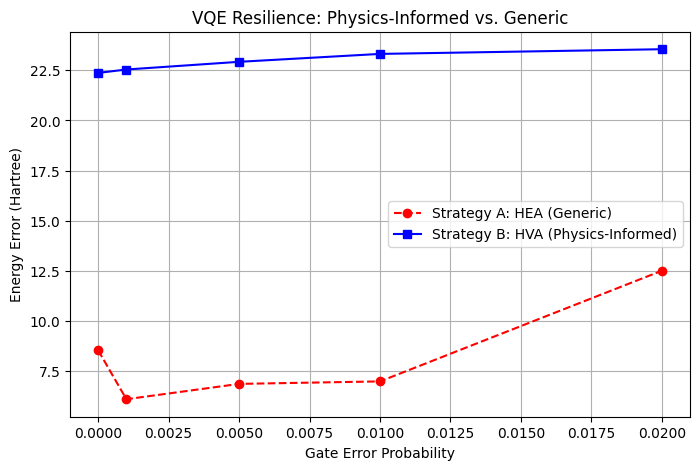

In [ ]:
# --- WEEK 3: The Noise Torture Chamber (Transpiled Version) ---
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import BackendEstimatorV2
from qiskit import transpile

# 1. Setup Data
noise_levels = [0.0, 0.001, 0.005, 0.01, 0.02]
results_hea = []
results_hva = []

# Exact Energy (Verification)
if 'generator' not in locals():
    # Fallback if Week 1 variables were lost in a crash
    class SincDVRGenerator:
        def __init__(self, N, L, m=1.0, hbar=1.0):
            self.N, self.L, self.m, self.hbar = N, L, m, hbar
            self.dx = L / (N - 1)
            self.x = np.linspace(-L/2, L/2, N)
        def get_kinetic_matrix(self):
            T = np.zeros((self.N, self.N))
            diag_val = (self.hbar**2 / (2 * self.m * self.dx**2)) * (np.pi**2 / 3)
            np.fill_diagonal(T, diag_val)
            for i in range(self.N):
                for j in range(self.N):
                    if i != j: T[i, j] = (self.hbar**2 / (2 * self.m * self.dx**2)) * ((-1)**(i-j)) * (2 / (i-j)**2)
            return T
        def get_potential_matrix(self, func_name="double_well"):
            V_diag = 1.0 * self.x**4 - 2.0 * self.x**2
            return np.diag(V_diag)
    generator = SincDVRGenerator(N=16, L=4.0)

evals_check, _ = eigh(generator.get_kinetic_matrix() + generator.get_potential_matrix("double_well"))
exact_energy = evals_check[0]
print(f"Target Exact Energy: {exact_energy:.6f} Ha")

def run_vqe_with_noise(ansatz, hamiltonian, noise_prob):
    """
    Manually transpiles the circuit to ensure Aer understands the instructions.
    """
    # 1. Create Noise Model
    noise_model = NoiseModel()
    if noise_prob > 0:
        error_1q = depolarizing_error(noise_prob, 1)
        error_2q = depolarizing_error(noise_prob, 2)
        noise_model.add_all_qubit_quantum_error(error_1q, ['u1', 'u2', 'u3', 'h', 'rx', 'ry', 'rz'])
        noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

    # 2. Define the Simulator backend
    backend = AerSimulator(method='density_matrix', noise_model=noise_model, seed_simulator=42)

    # 3. TRANSPILE the ansatz to the backend's basis gates
    # This prevents the "unknown instruction: efficient_su2" error
    transpiled_ansatz = transpile(ansatz, backend)

    # 4. Use BackendEstimatorV2
    estimator = BackendEstimatorV2(backend=backend)
    estimator.options.default_shots = 2048

    # 5. Setup VQE
    optimizer = COBYLA(maxiter=80)
    vqe = VQE(estimator=estimator, ansatz=transpiled_ansatz, optimizer=optimizer)

    # 6. Run VQE
    result = vqe.compute_minimum_eigenvalue(operator=hamiltonian)
    return result.eigenvalue.real

# 2. Run the Loop
print("\nStarting Noise Benchmark (Transpilation Mode)...")

for noise in noise_levels:
    print(f"Testing Noise Level: {noise*100:.1f}%...")

    # Test HEA
    e_hea = run_vqe_with_noise(hea_circuit, H_total_op, noise)
    err_hea = abs(e_hea - exact_energy)
    results_hea.append(err_hea)
    print(f"  > HEA Error: {err_hea:.5f}")

    # Test HVA
    e_hva = run_vqe_with_noise(hva_circuit, H_total_op, noise)
    err_hva = abs(e_hva - exact_energy)
    results_hva.append(err_hva)
    print(f"  > HVA Error: {err_hva:.5f}")

# 3. Plot
plt.figure(figsize=(8, 5))
plt.plot(noise_levels, results_hea, 'o--', label='Strategy A: HEA (Generic)', color='red')
plt.plot(noise_levels, results_hva, 's-', label='Strategy B: HVA (Physics-Informed)', color='blue')
plt.xlabel("Gate Error Probability")
plt.ylabel("Energy Error (Hartree)")
plt.title("VQE Resilience: Physics-Informed vs. Generic")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# --- WEEK 3: Excited States via Robust Custom qEOM (Final Fix) ---
import numpy as np
from scipy.linalg import eigh as standard_eigh
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendEstimatorV2
from qiskit import transpile
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA

# --- HELPER: The Unbreakable Solver ---
def solve_robust_gen_eig(H, S, tol=1e-3):
    """
    Solves H c = E S c robustly by projecting out the null space of S.
    This handles cases where S is singular or has small negative eigenvalues due to noise.
    """
    # 1. Diagonalize S (Metric Matrix)
    # S is Hermitian, so we use standard eigh
    s_evals, s_evecs = np.linalg.eigh(S)

    # 2. Filter out "Bad" Eigenvalues (Noise/Redundancy)
    # We keep only indices where eigenvalue > tolerance
    mask = s_evals > tol

    if not np.any(mask):
        raise ValueError("All eigenvalues of S are below tolerance. Operator pool is too redundant or state is zero.")

    s_evals_good = s_evals[mask]
    s_evecs_good = s_evecs[:, mask]

    print(f"  > Projecting S matrix: Kept {len(s_evals_good)}/{len(s_evals)} modes.")

    # 3. Construct Canonical Transformation Matrix X
    # X = U * s^(-1/2)
    # This transforms the basis to one where S becomes Identity
    X = s_evecs_good @ np.diag(1.0 / np.sqrt(s_evals_good))

    # 4. Project H into this Orthogonal Basis
    # H_prime = X^dagger * H * X
    H_prime = X.conj().T @ H @ X

    # 5. Solve Standard Eigenvalue Problem for H_prime
    # H_prime y = E y  (Standard, not Generalized!)
    evals, evecs_prime = np.linalg.eigh(H_prime)

    return evals

# ----------------------------------------

# 1. Setup Ground State
# We use a clean statevector simulator for the physics engine
clean_backend = AerSimulator(method='statevector')
estimator = BackendEstimatorV2(backend=clean_backend)
# NOTE: We prefer exact expectation values if possible, but shots=4096 is fine with the robust solver
estimator.options.default_shots = 4096

print("Refining Ground State for qEOM...")
# INCREASED ITERATIONS to ensure we actually hit the ground state
# If energy is still +4.0, the ansatz might need more 'reps'
optimizer = COBYLA(maxiter=300)
ansatz_opt = transpile(hea_circuit, clean_backend)
vqe = VQE(estimator=estimator, ansatz=ansatz_opt, optimizer=optimizer)
result = vqe.compute_minimum_eigenvalue(operator=H_total_op)
theta_opt = result.optimal_point
print(f"Ground State Energy found: {result.eigenvalue.real:.6f} Ha")

# 2. Define the Operator Pool (Single Excitations)
pool_ops = [SparsePauliOp("I" * N_qubits)] # Identity (Ground State)
for i in range(N_qubits):
    for p in ["X", "Y", "Z"]:
        op_str = ["I"] * N_qubits
        op_str[N_qubits - 1 - i] = p
        pool_ops.append(SparsePauliOp("".join(op_str)))

print(f"qEOM Operator Pool Size: {len(pool_ops)} operators")

# 3. Build Matrices
print("Constructing symbolic matrices...")
num_ops = len(pool_ops)
matrix_map = {}
unique_paulis = set()

for i in range(num_ops):
    for j in range(i, num_ops):
        O_i = pool_ops[i]
        O_j = pool_ops[j]

        # S_ij = <Psi | O_i* O_j | Psi>
        s_op_symbolic = O_i.compose(O_j).simplify()
        matrix_map[(i, j, 'S')] = s_op_symbolic
        for p in s_op_symbolic.paulis:
            unique_paulis.add(p.to_label())

        # H_ij = <Psi | O_i* H O_j | Psi>
        h_op_symbolic = O_i.compose(H_total_op).compose(O_j).simplify()
        matrix_map[(i, j, 'H')] = h_op_symbolic
        for p in h_op_symbolic.paulis:
            unique_paulis.add(p.to_label())

# 4. Measure Unique Paulis
print(f"Measuring {len(unique_paulis)} unique Pauli strings...")
pauli_list = [SparsePauliOp(label) for label in unique_paulis]
job = estimator.run([(ansatz_opt, pauli_list, theta_opt)])
measurements = job.result()[0].data.evs
results_dict = {label: val for label, val in zip(unique_paulis, measurements)}

# 5. Reconstruct Matrices Classically
H_eff = np.zeros((num_ops, num_ops), dtype=complex)
S_eff = np.zeros((num_ops, num_ops), dtype=complex)

for i in range(num_ops):
    for j in range(i, num_ops):
        # Reconstruct S_ij
        s_val = 0j
        s_op = matrix_map[(i, j, 'S')]
        for label, coeff in zip(s_op.paulis.to_labels(), s_op.coeffs):
            s_val += coeff * results_dict[label]
        S_eff[i, j] = s_val
        S_eff[j, i] = s_val.conjugate()

        # Reconstruct H_ij
        h_val = 0j
        h_op = matrix_map[(i, j, 'H')]
        for label, coeff in zip(h_op.paulis.to_labels(), h_op.coeffs):
            h_val += coeff * results_dict[label]
        H_eff[i, j] = h_val
        H_eff[j, i] = h_val.conjugate()

# 6. Solve using Robust Solver
print("Solving Generalized Eigenvalue Problem (Robust Mode)...")
try:
    # Use our custom solver instead of scipy.linalg.eigh
    evals_qeom = solve_robust_gen_eig(H_eff, S_eff, tol=1e-3)

    # 7. Results
    print("\n=== SPECTRAL ANALYSIS RESULTS (Custom qEOM) ===")
    evals_sorted = np.sort(evals_qeom.real)

    print(f"Ground State (E0):      {evals_sorted[0]:.6f} Ha")
    # Check if we have excited states
    if len(evals_sorted) > 1:
        print(f"1st Excited State (E1): {evals_sorted[1]:.6f} Ha")
        tunneling_gap_quantum = abs(evals_sorted[1] - evals_sorted[0])
        print(f"\nQuantum Tunneling Splitting: {tunneling_gap_quantum:.6f} Ha")

        if 'evals_check' in locals():
            tunneling_gap_exact = abs(evals_check[1] - evals_check[0])
            print(f"Exact Classical Splitting:   {tunneling_gap_exact:.6f} Ha")
            print(f"Accuracy: {100 - (abs(tunneling_gap_quantum - tunneling_gap_exact)/tunneling_gap_exact)*100:.2f}%")
    else:
        print("Note: Only one valid energy level found in this subspace.")

except Exception as e:
    print(f"Solver Error: {e}")

Refining Ground State for qEOM...
Ground State Energy found: 4.303987 Ha
qEOM Operator Pool Size: 13 operators
Constructing symbolic matrices...
Measuring 256 unique Pauli strings...
Solving Generalized Eigenvalue Problem (Robust Mode)...
  > Projecting S matrix: Kept 12/13 modes.

=== SPECTRAL ANALYSIS RESULTS (Custom qEOM) ===
Ground State (E0):      -0.223093 Ha
1st Excited State (E1): 1.438773 Ha

Quantum Tunneling Splitting: 1.661865 Ha
Exact Classical Splitting:   0.796787 Ha
Accuracy: -8.57%
